<a href="https://colab.research.google.com/github/Murcha1990/Raiff_PracticalML_May2023/blob/main/Lecture_4_PracticeEDA/Raiff_EDA_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи поиска оттоковых клиентов

* Загрузка данных и их анализ
* Обучение и оценка качества модели
  + обучение модели
  + оценка качества модели
* Интерпретация результатов модели
* Сохранение результатов

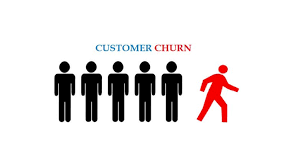

В курсе мы будем пользоваться следующими библиотеками Python:

*   Pandas - библиотеки для работы с таблицами
*   Numpy - библиотеки для быстрых и эффективных вычислений
*   Matplotlib - для визуализации данных
*   Sklearn - библиотеки с основными инструментами ML

С функционалом этих библиотек разберемся в процессе прохождения курса.

Будем решать задачу определения оттоковых клиентов,  а именно, *по характеристикам клиентов некоторого мобильного оператора будем определять, собираются ли клиенты сменить оператора или нет*.

## <font color='green'>1. Загрузка данных и их первичный анализ</font>

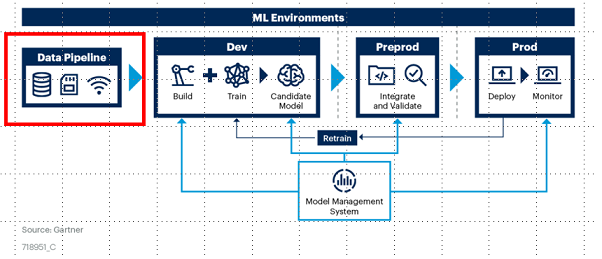

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

Подключаемся к БД и загружаем данные

In [ ]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-05-18 08:57:07--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-05-18 08:57:08 (859 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [ ]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:6 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
24 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
R

In [ ]:
import psycopg2

conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

In [ ]:
query = "SELECT * from public.clients"

data = pd.read_sql_query(query, conn)

conn.close()

Посмотрим на данные.

Описание данных клиентов:
* state, string. 2-letter code of the US state of customer residence
* account_length, numerical. Number of months the customer has been with the current telco provider
* area_code, string="area_code_AAA" where AAA = 3 digit area code.
* international_plan, (yes/no). The customer has international plan.
* voice_mail_plan, (yes/no). The customer has voice mail plan.
* number_vmail_messages, numerical. Number of voice-mail messages.
* total_day_minutes, numerical. Total minutes of day calls.
* total_day_calls, numerical. Total number of day calls.
* total_day_charge, numerical. Total charge of day calls.
* total_eve_minutes, numerical. Total minutes of evening calls.
* total_eve_calls, numerical. Total number of evening calls.
* total_eve_charge, numerical. Total charge of evening calls.
* total_night_minutes, numerical. Total minutes of night calls.
* total_night_calls, numerical. Total number of night calls.
* total_night_charge, numerical. Total charge of night calls.
* total_intl_minutes, numerical. Total minutes of international calls.
* total_intl_calls, numerical. Total number of international calls.
* total_intl_charge, numerical. Total charge of international calls
* number_customer_service_calls, numerical. Number of calls to customer service
* churn, (yes/no). Customer churn - target variable.




In [ ]:
data.tail(10)

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
3323,IN,117,415,No,No,0,118.4,126.0,20.13,249.3,97.0,21.19,227.0,56.0,10.22,13.6,3.0,3.67,5,True
3324,WV,159,415,No,No,0,169.8,114.0,28.87,197.7,105.0,16.80,193.7,82.0,8.72,11.6,4.0,3.13,1,False
3325,OH,78,408,No,No,0,193.4,99.0,32.88,116.9,88.0,9.94,243.3,109.0,10.95,9.3,4.0,2.51,2,False
3326,OH,96,415,No,No,0,106.6,128.0,18.12,284.8,87.0,24.21,178.9,92.0,8.05,14.9,7.0,4.02,1,False
3327,SC,79,415,No,No,0,134.7,98.0,22.90,189.7,68.0,16.12,221.4,128.0,9.96,11.8,5.0,3.19,2,False
3328,AZ,192,415,No,Yes,36,156.2,77.0,26.55,215.5,126.0,18.32,279.1,83.0,12.56,9.9,6.0,2.67,2,False
3329,WV,68,415,No,No,0,231.1,57.0,39.29,153.4,55.0,13.04,191.3,123.0,8.61,9.6,4.0,2.59,3,False
3330,RI,28,510,No,No,0,180.8,109.0,30.74,288.8,58.0,24.55,191.9,91.0,8.64,14.1,6.0,3.81,2,False
3331,CT,184,510,Yes,No,0,213.8,105.0,36.35,159.6,84.0,13.57,139.2,137.0,6.26,5.0,10.0,1.35,2,False
3332,TN,74,415,No,Yes,25,234.4,113.0,39.85,265.9,82.0,22.60,241.4,77.0,10.86,13.7,4.0,3.70,0,False


In [ ]:
data.shape 

(3333, 20)

In [ ]:
data.dtypes

state                    object
accountlength             int64
areacode                  int64
internationalplan        object
voicemailplan            object
numbervmailmessages       int64
totaldayminutes         float64
totaldaycalls           float64
totaldaycharge          float64
totaleveminutes         float64
totalevecalls           float64
totalevecharge          float64
totalnightminutes       float64
totalnightcalls         float64
totalnightcharge        float64
totalintlminutes        float64
totalintlcalls          float64
totalintlcharge         float64
customerservicecalls      int64
churn                      bool
dtype: object

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state                 3333 non-null   object 
 1   accountlength         3333 non-null   int64  
 2   areacode              3333 non-null   int64  
 3   internationalplan     3333 non-null   object 
 4   voicemailplan         3333 non-null   object 
 5   numbervmailmessages   3333 non-null   int64  
 6   totaldayminutes       3333 non-null   float64
 7   totaldaycalls         3333 non-null   float64
 8   totaldaycharge        3333 non-null   float64
 9   totaleveminutes       3333 non-null   float64
 10  totalevecalls         3333 non-null   float64
 11  totalevecharge        3333 non-null   float64
 12  totalnightminutes     3333 non-null   float64
 13  totalnightcalls       3333 non-null   float64
 14  totalnightcharge      3333 non-null   float64
 15  totalintlminutes     

## Сохранение данных

In [ ]:
data.to_csv("churn_clients.csv", index=False)

In [ ]:
data = pd.read_csv("churn_clients.csv")

# Разведочный анализ данных

## 1. Оценка качества данных
* пропущенные значения
* ошибочные значения

In [ ]:
len(data)

3333

Посмотрим, есть ли в данных пропущенные значения.

In [ ]:
data.isna().sum()

state                   0
accountlength           0
areacode                0
internationalplan       0
voicemailplan           0
numbervmailmessages     0
totaldayminutes         0
totaldaycalls           0
totaldaycharge          0
totaleveminutes         0
totalevecalls           0
totalevecharge          0
totalnightminutes       0
totalnightcalls         0
totalnightcharge        0
totalintlminutes        0
totalintlcalls          0
totalintlcharge         0
customerservicecalls    0
churn                   0
dtype: int64

### Обработка пропущенных значений

Пропусков в данных нет. А что делать, если бы были?

Немного испортим данные.

In [ ]:
import numpy as np

data.loc[np.random.choice(len(data),50), 'areacode'] = np.nan
data.loc[np.random.choice(len(data),10), 'totaldayminutes'] = np.nan
data.loc[np.random.choice(len(data),5), 'totaleveminutes'] = np.nan
data.loc[np.random.choice(len(data),20), 'voicemailplan'] = "Nou"

In [ ]:
data.isna().sum()

state                    0
accountlength            0
areacode                49
internationalplan        0
voicemailplan            0
numbervmailmessages      0
totaldayminutes         10
totaldaycalls            0
totaldaycharge           0
totaleveminutes          5
totalevecalls            0
totalevecharge           0
totalnightminutes        0
totalnightcalls          0
totalnightcharge         0
totalintlminutes         0
totalintlcalls           0
totalintlcharge          0
customerservicecalls     0
churn                    0
dtype: int64

Areacode - **категориальный признак** (это код области, не число по сути). Обычно пропуски в таких признаках заполняют некоторой уникальной категорией.

In [ ]:
data.count()

state                   3333
accountlength           3333
areacode                3284
internationalplan       3333
voicemailplan           3333
numbervmailmessages     3333
totaldayminutes         3323
totaldaycalls           3333
totaldaycharge          3333
totaleveminutes         3328
totalevecalls           3333
totalevecharge          3333
totalnightminutes       3333
totalnightcalls         3333
totalnightcharge        3333
totalintlminutes        3333
totalintlcalls          3333
totalintlcharge         3333
customerservicecalls    3333
churn                   3333
dtype: int64

In [ ]:
data.areacode.value_counts(dropna=False)

415.0    1632
510.0     829
408.0     823
NaN        49
Name: areacode, dtype: int64

* пропусков меньше 1% - можно выкинуть строки с пропусками

* пропусков меньше 10% - заполняем пропуск каким-то значением

In [ ]:
data['areacode'] = data['areacode'].fillna(-100)

In [ ]:
data.areacode.value_counts()

 415.0    1632
 510.0     829
 408.0     823
-100.0      49
Name: areacode, dtype: int64

Totaldayminutes - **числовой признак**. Пропуски в числовых признаках обычно заполняют средним значением или медианой.

In [ ]:
median = data['totaldayminutes'].median()

print(median)

data['totaldayminutes'].fillna(median, inplace=True)

179.4


In [ ]:
print(median)

In [ ]:
data.isna().sum()

state                   0
accountlength           0
areacode                0
internationalplan       0
voicemailplan           0
numbervmailmessages     0
totaldayminutes         0
totaldaycalls           0
totaldaycharge          0
totaleveminutes         0
totalevecalls           0
totalevecharge          0
totalnightminutes       0
totalnightcalls         0
totalnightcharge        0
totalintlminutes        0
totalintlcalls          0
totalintlcharge         0
customerservicecalls    0
churn                   0
dtype: int64

Заполните пропуски в столбце totaleveminutes медианным значением.

In [ ]:
# your code here

median = data['totaleveminutes'].median()

data['totaleveminutes'].fillna(median, inplace=True)

## Вопрос для Quiz

Чему равна медиана в столбце totaleveminutes? Ответ округлите до целого числа.

## Ошибочные значения

Выведите на экран число различных значений в столбце voicemailplan, используя value_counts

In [ ]:
data['voicemailplan'].value_counts()

No     2401
Yes     912
Nou      20
Name: voicemailplan, dtype: int64

## Вопрос для Quiz

Сколько строк содержат ошибочное значение в столбце voicemailplan?

In [ ]:
data['voicemailplan'] = data['voicemailplan'].replace('Nou', 'No')

In [ ]:
data['voicemailplan'].value_counts()

No     2421
Yes     912
Name: voicemailplan, dtype: int64

In [ ]:
# data['is_date'] = data['date'].apply(lambda x: 1 if x.isna() else 0)

## Основные числовые характеристики

Есть сильный дисбаланс классов!

In [ ]:
data['churn'].value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

In [ ]:
data.describe()

,accountlength,areacode,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,429.329133,8.099010,179.768827,100.435644,30.562307,201.017462,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,77.152450,13.688365,54.322508,20.069084,9.259435,50.685491,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.800000,87.000000,24.430000,166.700000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,415.000000,20.000000,216.200000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


<Axes: >

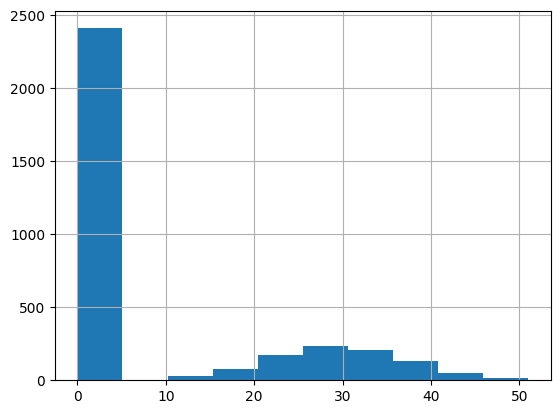

In [ ]:
data['numbervmailmessages'].hist()

In [ ]:
data.describe(include='object') # категориальные колонки

,state,internationalplan,voicemailplan
count,3333,3333,3333
unique,51,2,2
top,WV,No,No
freq,106,3010,2421


In [ ]:
corr = data.corr() # строим матрицу корреляций

corr.style.background_gradient(cmap='coolwarm')

,accountlength,areacode,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
accountlength,1.000000,-0.016028,-0.004628,0.007094,0.038470,0.006214,-0.006432,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796,0.016541
areacode,-0.016028,1.000000,0.004615,-0.020969,-0.014489,-0.021825,-0.006230,0.005936,-0.007688,-0.002667,0.017913,-0.002665,-0.001939,-0.016832,-0.001998,0.007453,-0.003292
numbervmailmessages,-0.004628,0.004615,1.000000,0.002247,-0.009548,0.000776,0.018515,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263,-0.089728
totaldayminutes,0.007094,-0.020969,0.002247,1.000000,0.007256,0.997339,0.007876,0.016474,0.007495,0.005944,0.024420,0.005923,-0.008841,0.009921,-0.008778,-0.013600,0.202725
totaldaycalls,0.038470,-0.014489,-0.009548,0.007256,1.000000,0.006753,-0.021874,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942,0.018459
totaldaycharge,0.006214,-0.021825,0.000776,0.997339,0.006753,1.000000,0.007416,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427,0.205151
totaleveminutes,-0.006432,-0.006230,0.018515,0.007876,-0.021874,0.007416,1.000000,-0.011748,0.999435,-0.013432,0.007424,-0.013441,-0.011682,0.002440,-0.011714,-0.013215,0.092546
totalevecalls,0.019260,0.005936,-0.005864,0.016474,0.006462,0.015769,-0.011748,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423,0.009233
totalevecharge,-0.006745,-0.007688,0.017578,0.007495,-0.021449,0.007036,0.999435,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987,0.092786
totalnightminutes,-0.008955,-0.002667,0.007681,0.005944,0.022938,0.004324,-0.013432,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288,0.035493


In [ ]:
data = data.drop(['totaldaycharge','totalnightcharge','totalintlcharge','totalevecharge'],axis=1)

In [ ]:
for col in data.columns:
    try:
        print(col, np.corrcoef(data[col], data['churn'])[0][1])
    except:
        pass

accountlength 0.016540742243674116
areacode -0.003292256983472277
numbervmailmessages -0.08972796983506436
totaldayminutes 0.20272471998880998
totaldaycalls 0.018459311608576896
totaleveminutes 0.09254621352446346
totalevecalls 0.009233131913078275
totalnightminutes 0.03549285342127401
totalnightcalls 0.006141203007399705
totalintlminutes 0.06823877562717724
totalintlcalls -0.05284433577413811
customerservicecalls 0.20874999878379402
churn 1.0


## Вопрос для Quiz

Какой признак имеет наибольшую корреляцию с целевой переменной (churn)?

## Визуализация данных

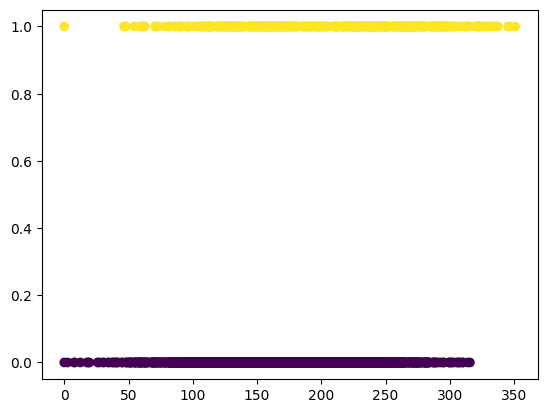

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(data['totaldayminutes'], data['churn'], c=data['churn'])

In [ ]:
data.groupby('churn')['totaldayminutes'].mean()

churn
False    175.235965
True     206.515528
Name: totaldayminutes, dtype: float64

Постройте диаграмму рассеяния для оценки влияния признака customerservicecalls на целевую переменную churn.

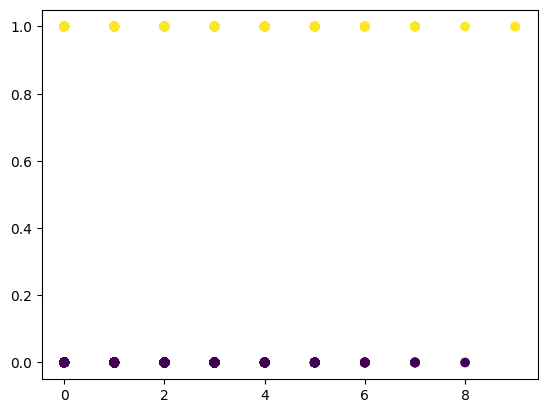

In [ ]:
# your code here

plt.scatter(data['customerservicecalls'], data['churn'], c=data['churn'])

<Axes: >

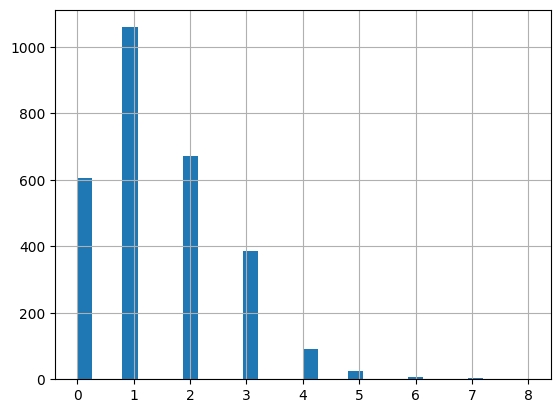

In [ ]:
data[data.churn == 0]['customerservicecalls'].hist(bins=30)

<Axes: >

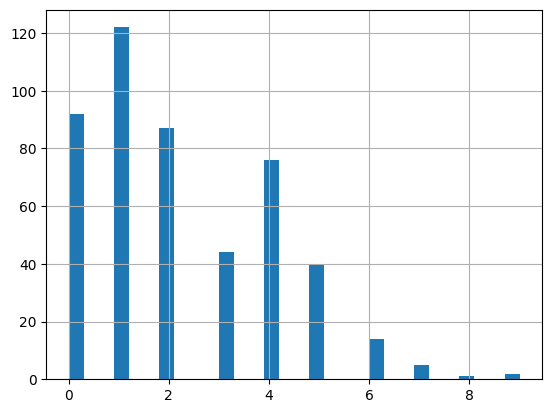

In [ ]:
data[data.churn == 1]['customerservicecalls'].hist(bins=30)

Посчитайте среднее значение customerservicecalls для оттоковых и не оттоковых клиентов, используйте groupby.

In [ ]:
# your code here

data.groupby('churn')['customerservicecalls'].mean()

churn
False    1.449825
True     2.229814
Name: customerservicecalls, dtype: float64

## Вопрос для Quiz

У каких клиентов больше среднее значение customerservicecalls?

## <font color='green'>2.1. Обучение модели</font>



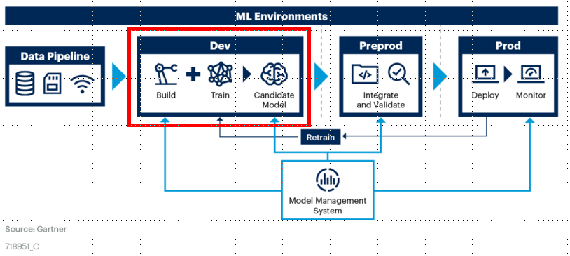

Сформируем матрицу X объект-признак и вектор y целевой переменной.

In [ ]:
X = data.drop('churn', axis=1) # матрица объект-признак
y = data['churn'] # целевая переменная

Когда мы решаем задачу классификации, мы можем захотеть предсказывать не только классы, но и их вероятности. Для целей бизнеса, например, полезно знать, с какой вероятностью клиент вернет кредит (а не просто - вернет кредит или не вернет). Например, если клиент уйдет из банка с вероятностью 0.95, то это очень ненадежный клиент. А если с вероятностью 0.52  - этот клиент под вопросом. Но с точки зрения бинарной классификации для обоих клиентов модель предскажет, что они уйдут, так как стандартный порог перевода вероятности в классы - 0.5. 

* задача классификации, в которой модель предсказывает только классы - это **жесткая классификация**
* если же классификатор предсказывает вероятности классов - это **мягкая классификация**

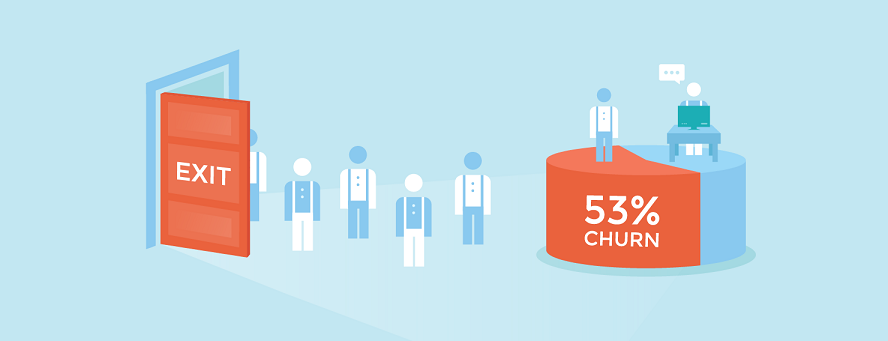

**Логистическая регрессия** - это линейный классификатор, который кроме классов умеет предсказывать вероятности классов.

Модель делает предсказания по формуле
$$a(x) = \sigma(w_0 + w_1x_1 + w_2x_2 + ...),$$
то есть умножает признаки объекта $x_1,x_2,...$ на некоторые веса $w_0,w_1,w_2,...$

Например, если 
* $x_1$ - возраст клиента
* $x_2$ - число жалоб клиента на банк, 
то обученная модель может иметь вид
$$a(x) = \sigma(10 - 3x_1 + 50x_2)$$

Веса модели подбираются автоматически так, чтобы ошибка предсказания модели была минимальной.

Функция $\sigma(x)$ - переводит предсказания модели в вероятности:

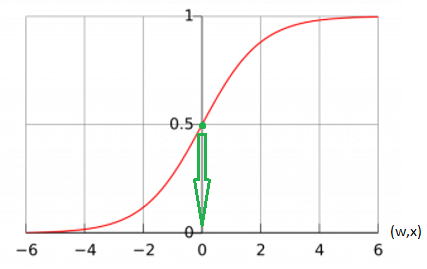

Давайте применим логистическую регрессию для поиска оттоковых клиентов!

Сначала выкинем нечисловые столбцы.

In [ ]:
X = X.drop(['state','areacode','voicemailplan','internationalplan'], axis=1)

In [ ]:
X.head()

,accountlength,numbervmailmessages,totaldayminutes,totaldaycalls,totaleveminutes,totalevecalls,totalnightminutes,totalnightcalls,totalintlminutes,totalintlcalls,customerservicecalls
0,128,25,265.1,110.0,197.4,99.0,244.7,91.0,10.0,3.0,1
1,107,26,161.6,123.0,195.5,103.0,254.4,103.0,13.7,3.0,1
2,137,0,243.4,114.0,121.2,110.0,162.6,104.0,12.2,5.0,0
3,84,0,299.4,71.0,61.9,88.0,196.9,89.0,6.6,7.0,2
4,75,0,166.7,113.0,148.3,122.0,186.9,121.0,10.1,3.0,3


Разобъём данные на train и test (test — 25% от всех данных). Зачем это делается?

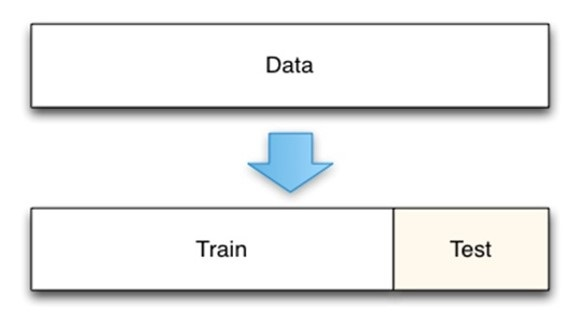

Мы разбиваем данные на train и test, чтобы:
* на тренировочных данных обучить модель
* на тестовых применить обученную модель и затем проверить качество модели

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

## Вопрос для Quiz

В одинаковых ли масштабах измеряются признаки клиентов?

Для ответа на этот вопрос выведите на экран первые несколько строчек таблицы X (вам поможет функция head).

In [ ]:
# your code here

Для линейных моделей очень важно масштабирование признаков. Поэтому отмасштабируем признаки при помощи StandardScaler, обучив метод на тренировочных данных и применив его и к трейну, и к тесту.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

,accountlength,numbervmailmessages,totaldayminutes,totaldaycalls,totaleveminutes,totalevecalls,totalnightminutes,totalnightcalls,totalintlminutes,totalintlcalls,customerservicecalls
0,-1.404508,-0.584700,-1.886522,1.330852,1.038293,0.401340,1.069609,0.004940,2.768109,-0.595235,-0.427903
1,0.366388,-0.584700,0.293965,0.529165,0.516333,0.401340,2.214376,0.670832,1.051970,-1.417963,0.324616
2,0.518179,1.685101,1.057228,-1.875896,0.093229,0.849774,-0.077125,-0.763398,-0.056369,0.227493,1.829653
3,2.010792,-0.584700,-0.680492,1.681590,-0.403029,0.650470,-0.322994,-0.660953,-0.056369,-0.183871,-0.427903
4,0.290493,-0.584700,0.484781,1.080325,-0.719368,-0.296224,-1.186487,0.056162,0.837453,1.050221,1.077134


Обучим логистическую регрессию на train и сделаем предсказание на новых для нее данных (test).

In [ ]:
from sklearn.linear_model import LogisticRegression # линейная модель для задачи классификации

model = LogisticRegression() # объявление модели

model.fit(Xtrain, ytrain) # обучение модели

LogisticRegression()

In [ ]:
pred_test = model.predict(Xtest) # предсказание классов

Посмотрим на предсказания модели и оценим ее качество.

In [ ]:
pred_test

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
accuracy_score(ytest, pred_test) 

0.8465227817745803

## Вопрос для Quiz

Доля верно определенных классов высокая! Значит ли это, что качество хорошее?


Проверим, сбалансирована ли выборка.

In [ ]:
y.value_counts()

False    2850
True      483
Name: churn, dtype: int64

Баланса классов нет: большинство клиентов не собирается менять банк ($y=0$). 

Посмотрим, что предсказывает модель.

In [ ]:
pred_test[:20]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

## <font color='green'>2.2. Валидация модели</font>

Для оценки качества модели используются различные метрики качества. Давайте посмотрим, какие метрики полезно считать в задаче классификации, кроме accuracy.

<font color='blue'>Для оценки качества моделей бинарной классификации полезно смотреть на **матрицу ошибок** (confusion matrix):</font>

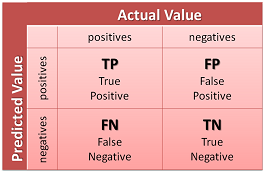

Эта матрица состоит из четырех чисел:

* **True Positive (TP)** - количество объектов положительного класса, предсказанных моделью как положительные (верные предсказания)
* **False Positive (FP)** - количество объектов отрицательного класса, предсказанных моделью как положительные (ошибки модели)
* **False Negative (FN)** - количество объектов положительного класса, предсказанных моделью как отрицательные (ошибки модели)
* **True Negative (TN)** - количество объектов отрицательного класса, предсказанных моделью как отрицательные (верные предсказания).

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytest, pred_test)

In [ ]:
ytest.value_counts()

Модель верно определила очень мало оттоковых клиентов :(

<font color='blue'>Также можно посмотреть на метрику **recall (полнота)** - она показывает, какую долю оттоковых клиентов (объектов положительного класса) нашла модель.</font>

In [ ]:
from sklearn.metrics import recall_score

recall_score(ytest, pred_test)

## Вопрос для Quiz

Что означает это значение метрики recall?

Давайте разберемся, почему так произошло?

Посмотрим на вероятности, выдаваемые моделью.

In [ ]:
probs = model.predict_proba(Xtest)

probs[:10]

Модель слишком позитивна. Она присваивает классу 0 (клиент не уйдет) всегда большие вероятности. 

<font color='blue'>Попробуем изменить **порог для перевода вероятности в классы** со стандартного 0.5 на порог поменьше.</blue>

In [ ]:
probs_churn = probs[:,1]

classes = probs_churn > 0.2

In [ ]:
confusion_matrix(ytest, classes)

In [ ]:
ytest.value_counts()

In [ ]:
recall_score(ytest, classes)

Теперь модель стала находить оттоковых клиентов, но и больше ошибается на тех клиентах, которые не уйдут.

## <font color='green'>3. Интерпретация модели</font>

После обучения модели можно посмотреть на её веса, то есть на коэффициенты при признаках, найденные моделью.

In [ ]:
model.coef_, model.intercept_

(array([[ 0.06584498, -0.30701139,  0.31479709,  0.01442553,  0.3148823 ,
          0.15265995,  0.04292986,  0.15237034,  0.05383781,  0.01156402,
          0.05346644,  0.14409823, -0.20621332,  0.14457418,  0.6019273 ]]),
 array([-2.12115493]))

In [ ]:
import pandas as pd

coef_table = pd.DataFrame({'features' : list(X.columns), 'weights' : list(model.coef_[0])})

coef_table.sort_values(by='weights')

,features,weights
1,numbervmailmessages,-0.307011
12,totalintlcalls,-0.206213
9,totalnightcalls,0.011564
3,totaldaycalls,0.014426
6,totalevecalls,0.042930
10,totalnightcharge,0.053466
8,totalnightminutes,0.053838
0,accountlength,0.065845
11,totalintlminutes,0.144098
13,totalintlcharge,0.144574


Если вес у признака положительный, то признак вносит положительный вклад в ответ, то есть чем больше значение признака, тем больше это дает вклад в положительный класс объекта и наоборот.

## Метод ближайших соседей (бонус)

Существует еще один простой метод для решения задач классификации - метод ближайших соседей.

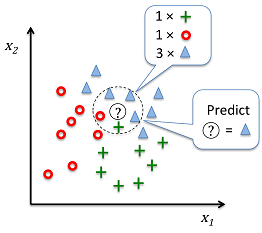

Попробуем применить метод ближайших соседей для решения поставленной задачи.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [ ]:
knn.fit(Xtrain, ytrain)

pred_test2 = knn.predict_proba(Xtest)[:,1]

classes2 = pred_test2 > 0.1

confusion_matrix(ytest, classes2)

array([[469, 240],
       [ 28,  97]])

## Вопрос для Quiz

Вычислите recall (долю найденных моделью оттоковых клиентов) при пороге 0.1. Ответ не округляйте.

In [ ]:
# your code here

## <font color='green'>4. Сохранение результатов экспериментов</font>

Что сохраняем?

* Предсказания модели
* Эксперименты
* Модель

Сначала сохраним предсказания модели в файл:

In [ ]:
Xtest['predictions'] = probs_churn

Xtest[['predictions']].to_csv("PredictionsChurn.csv", index=False)

Теперь сохраним саму модель:

In [ ]:
import pickle 

with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

# а так модель можно загрузить из файла:  
# with open('filename.pickle', 'rb') as f:
#     model = pickle.load(f)

Сохраним полученную модель, файл с предсказаниями и ноутбук с экспериментами на гитхаб.

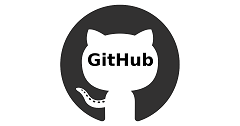

## <font color='green'>5. Градиентный бустинг</font>

Мы поработали с линейными моделями. Они весьма и весьма простые — предполагают независимость признаков и линейную связь между каждым признаком и целевой переменной. Конечно, в наших данных вряд ли всё так просто. Можно пытаться усложнять линейные модели: добавлять нелинейные признаки, переходить в новое признаковое пространство. Но это всё полумеры.

Сейчас мы поработаем с градиентным бустингом — одним из самых мощных подходов для работы с табличными данными.

Пока не ушли далеко — посчитаем и запомним качество логистической регрессии.

In [ ]:
from sklearn import metrics

print("LR quality:")
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, probs[:, 1]))

LR quality:
precision:  0.39901477832512317
recall:  0.648
auc-roc:  0.7885585331452751


Есть много имплементаций градиентного бустинга. Мы будем пользоваться CatBoost — библиотекой от Яндекса, которая очень эффективно написана и широко используется в мире.

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
train_set = Pool(Xtrain, ytrain)
test_set = Pool(Xtest, ytest)

In [ ]:
gbm = CatBoostClassifier(iterations=100,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(Xtest)

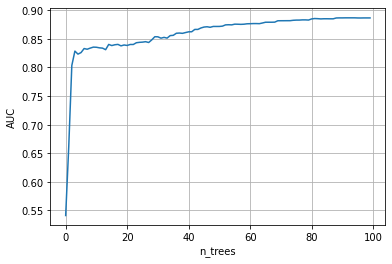

In [ ]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()

In [ ]:
gbm_classes = (gbm_preds[:, 1] > 0.3)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

precision:  0.7346938775510204
recall:  0.576
auc-roc:  0.8868265162200282


In [ ]:
coef_table = pd.DataFrame({'features' : list(X.columns), 'importances' : list(gbm.get_feature_importance())})

coef_table.sort_values(by='importances')

,features,importances
3,totaldaycalls,0.000000
5,totalevecalls,0.009837
7,totalnightcalls,0.069067
0,accountlength,0.211131
6,totalnightminutes,1.434716
9,totalintlcalls,5.150191
1,numbervmailmessages,5.545506
8,totalintlminutes,6.831508
4,totaleveminutes,10.295718
10,customerservicecalls,29.734287


## Вопрос для Quiz

Попробуйте обучить градиентный бустинг с другой длиной шага. Получится ли улучшить AUC-ROC на тесте?

In [ ]:
# ваш код здесь

## <font color='green'>6. Обработка категориальных признаков</font>

Выше мы удаляли все категориальные столбцы:

`X = X.drop(['state','areacode','voicemailplan','internationalplan'], axis=1)`

А вдруг там содержится много полезной информации? Попробуем её сохранить.

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_full, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = ['state','areacode','voicemailplan','internationalplan']
numeric_features = X.columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

X_transformed = column_transformer.fit_transform(Xtrain)
X_test_transformed = column_transformer.transform(Xtest)

In [ ]:
X_transformed.shape

(2499, 69)

In [ ]:
model = LogisticRegression()
model.fit(X_transformed, ytrain)
pred = model.predict_proba(X_test_transformed)

In [ ]:
classes = (pred[:, 1] > 0.5)
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, pred[:, 1]))

precision:  0.5681818181818182
recall:  0.2
auc-roc:  0.8343244005641749


In [ ]:
train_set = Pool(X_transformed, ytrain)
test_set = Pool(X_test_transformed, ytest)
gbm = CatBoostClassifier(iterations=100,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(test_set)
gbm_classes = (gbm_preds[:, 1] > 0.3)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

precision:  0.8495575221238938
recall:  0.768
auc-roc:  0.9301156558533146
